In [9]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications import DenseNet121
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

### Data Collection and Prep

In [10]:
# change this with naming schematic
gesture_name = ['wave', 'pointup', 'rockon', 'pointright']

gestures = {'wave':'Hello',
            'pointup':'Volume_Up',
            'rockon':'Play',
            'pointright':'Next'}

gestures_map = {'Hello' : 0,
                'Volume_Up': 1,
                'Play': 2,
                'Next': 3,
                }

In [11]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data, num_classes=5)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = [] 
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file.split('_')[0]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))   

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

def augment_data(img_path, train_batch_size, directory, prefix, generation_count):
    try:
        test_datagen = ImageDataGenerator(rescale=1./255, 
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2) 

        x = load_img(img_path)
        x = img_to_array(x)
        x = x.reshape((1, ) + x.shape)

        i = 0
        for batch in test_datagen.flow(x, batch_size=train_batch_size,
                              save_to_dir=directory, save_prefix=prefix, save_format='png'):
            i += 1
            if i > generation_count:
                return 1
                break
    except:
        return 0

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

In [12]:
rgb = True
relative_path = './../../data/'
X_data, y_data = walk_file_tree(relative_path)
train_batch_size = 64
for i in range(4):
    img_len = (sum(np.argmax(y_data, axis=1) == i))
    for j in range(0, img_len, 20):
        img = gesture_name[i]
        file_path = '../data/original/' + gesture_name[i] + '_' + str(j) + '.png'
        res = augment_data(file_path, train_batch_size, './../../data/aug', gesture_name[i]+'_' + str(j), 2)

In [13]:
rgb = True
X_data, y_data = walk_file_tree(relative_path)
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (6930, 224, 224, 3)
y_data shape: (6930, 5)


In [14]:
# initial test train split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

# train val split with train data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=12, stratify=y_train)

### Model Prep and Train

In [15]:
file_path = './../../models/dense_model.h5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)
imageSize = 224

In [16]:
dense_base = DenseNet121(weights='imagenet', include_top = False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()
base_model =  dense_base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

training
Train on 4435 samples, validate on 1109 samples
Epoch 1/3
4435/4435 [==============================] - 270s 61ms/step - loss: 0.3146 - accuracy: 0.9062 - val_loss: 0.3838 - val_accuracy: 0.8828
Epoch 2/3
4435/4435 [==============================] - 265s 60ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.2356 - val_accuracy: 0.9432
Epoch 3/3
4435/4435 [==============================] - 269s 61ms/step - loss: 0.0270 - accuracy: 0.9948 - val_loss: 0.3069 - val_accuracy: 0.9414


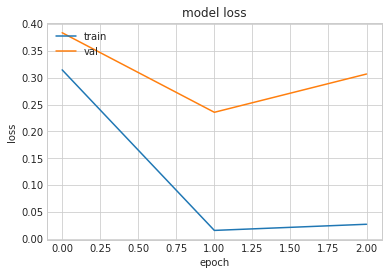

In [17]:
# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("training")
history = model.fit(X_train, y_train, epochs=3, batch_size=train_batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, model_checkpoint])

# plots the model 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./../results/Dense_Loss.png') 

### Model Evaluation

In [18]:
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))
print(confusion_matrix(y_test_bool, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       445
           1       0.90      1.00      0.95       431
           2       1.00      0.62      0.77       146
           3       0.92      1.00      0.96       364

    accuracy                           0.94      1386
   macro avg       0.96      0.89      0.91      1386
weighted avg       0.95      0.94      0.94      1386

[[423   3   0  19]
 [  0 430   0   1]
 [  0  42  91  13]
 [  0   1   0 363]]
